In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR

import matplotlib.pyplot as plt

In [2]:
def cosine_power_annealing(
    epochs=None,
    max_lr=0.1,
    min_lr=1e-4,
    exponent_order=10,
    max_epoch=None,
    warmup_epochs=None,
    return_intermediates=False,
    start_epoch=1,
    restart_lr=True,
):
    """Cosine Power annealing is designed to be an improvement on cosine annealing.

    Often the cosine annealing schedule decreases too slowly at the beginning
    and to quickly at the end. A simple exponential annealing curve does the
    opposite, decreasing too quickly at the beginning and too slowly at the end.
    Power cosine annealing strikes a configurable balance between the two.
    The larger the exponent order, the faster exponential decay occurs.
    The smaller the exponent order, the more like cosine annealing the curve becomes.

    # Arguments

    epochs: An integer indicating the number of epochs to train.
        If you are resuming from epoch 100 and want to run until epoch 300,
        specify 200.
    max_lr: The maximum learning rate which is also the initial learning rate.
    min_lr: The minimum learning rate which is also the final learning rate.
    exponent_order: Determines how fast the learning rate decays.
        A value of 1 will perform standard cosine annealing, while
        10 will decay with an exponential base of 10.
    max_epoch: The maximum epoch number that will be encountered.
        This is usually specified for when you are getting a single learning rate
        value at the current epoch, or for resuming training runs.
    return_intermediates: True changes the return value to be
        [cos_power_annealing, cos_power_proportions, cos_proportions]
        which is useful for comparing, understanding, and plotting several possible
        learning rate curves. False returns only the cos_power_annealing
        learning rate values.,
    start_epoch: The epoch number to start training from which will be at index 0
        of the returned numpy array.
    restart_lr: If True the training curve will be returned as if starting from
        epoch 1, even if you are resuming from a later epoch. Otherwise we will
        return with the learning rate as if you have already trained up to
        the value specified by start_epoch.

    # Returns

        A 1d numpy array cos_power_annealing, which will contain the learning
        rate you should use at each of the specified epochs.
    """
    if epochs is None and max_epoch is None:
        raise ValueError(
            'cosine_power_annealing() requires either the "epochs" parameter, "max_epochs" parameter, '
            'or both to be specified. "epochs" can be a single value or an array of epoch values, but got '
            + str(epochs)
            + '. "max_epoch" can be a single value, but got '
            + str(max_epoch)
            + "."
        )
    elif epochs is None:
        epochs = np.arange(max_epoch) + 1
    elif isinstance(epochs, int):
        epochs = np.arange(epochs) + 1
    if max_epoch is None:
        max_epoch = np.max(epochs)

    if warmup_epochs is not None and warmup_epochs > 0:
        min_epoch = np.min(epochs)
        if min_epoch > 1:
            raise ValueError(
                "cosine_power_annealing(): "
                "Resuming training with warmup enabled is not yet directly supported! "
                "The workaround is to create a training curve starting from 1, "
                "then get your learning rates by indexing from your current epoch onwards. "
                "Expected: warmup_epochs=None or np.min(epochs)=1, "
                "but got warmup_epochs="
                + str(warmup_epochs)
                + " and np.min(epochs)="
                + str(min_epoch)
            )
        # change warmup epochs to do some warmup
        warmups = epochs <= warmup_epochs + min_epoch
        max_epoch -= warmup_epochs
        epochs -= warmup_epochs

    # first half of cosine curve scaled from 1 to 0
    cos_proportions = (1 + np.cos(np.pi * epochs / max_epoch)) / 2
    # power curve applied to cosine values
    if exponent_order < 1:
        raise ValueError(
            'cosine_power_annealing() requires the "exponent order" parameter '
            "to be greater than or equal to 1 but got " + str(exponent_order) + "."
        )
    elif exponent_order == 1:
        cos_power_proportions = cos_proportions
    else:
        cos_power_proportions = np.power(exponent_order, cos_proportions + 1)
    # rescale the power curve from the current range to be from 1 to 0
    cos_power_proportions = cos_power_proportions - np.min(cos_power_proportions)
    cos_power_proportions = cos_power_proportions / np.max(cos_power_proportions)
    # check if we are doing warmup
    if warmup_epochs is not None and warmup_epochs > 0:
        # set the proportion values which apply during the warmup phase
        warmup_end = min_epoch + warmup_epochs
        cos_power_proportions[warmups] = np.arange(min_epoch, warmup_end + 1) / float(
            warmup_end
        )
    # rescale the power curve between the user specified min and max learning rate
    cos_power_annealing = (cos_power_proportions * (max_lr - min_lr)) + min_lr

    if start_epoch > 1:
        # If we are resuming, extract the portion of the curve
        # the user asked for.
        if restart_lr:
            cos_power_annealing = cos_power_annealing[: len(epochs)]
        else:
            cos_power_annealing = cos_power_annealing[start_epoch - 1 :]

    if return_intermediates:
        return cos_power_annealing, cos_power_proportions, cos_proportions
    else:
        return cos_power_annealing


In [3]:
model = nn.Linear(10, 1)

# 학습 데이터와 레이블 준비
train_data = torch.randn((100, 10))
train_labels = torch.randn((100, 1))

epochs = 80

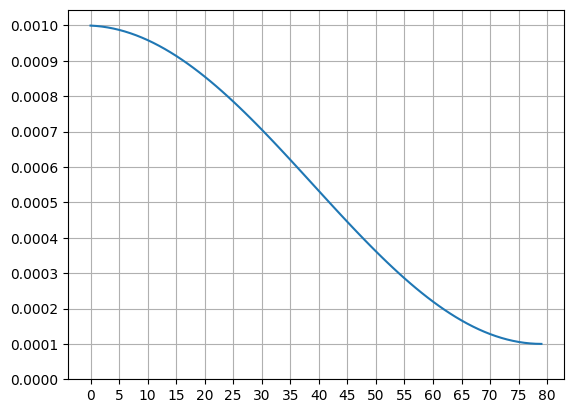

In [4]:
optimizer = optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-4)
recode_lrs = []
for epoch in range(epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    recode_lrs.append(current_lr)

fig, ax = plt.subplots()
ax.plot(recode_lrs)

x_ticks = np.arange(0, epochs+1, step=5)
y_ticks = np.arange(0, 1.1e-3, step=0.0001)

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
plt.grid(True)
plt.show()

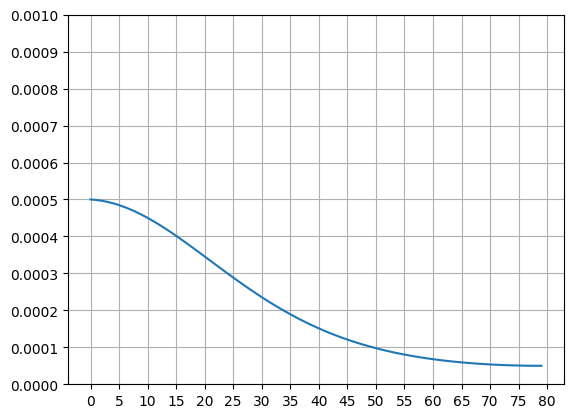

In [5]:
lrs = cosine_power_annealing(
    epochs,
    max_lr=5,
    min_lr=0.5,
    exponent_order=10,
    warmup_epochs=None,
    return_intermediates=False,
    start_epoch=1,
    restart_lr=True,
    )
optimizer = optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = LambdaLR(optimizer, lr_lambda=lambda i: lrs[i-1])
recode_lrs = []
for epoch in range(epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    recode_lrs.append(current_lr)

fig, ax = plt.subplots()
ax.plot(recode_lrs)

x_ticks = np.arange(0, epochs+1, step=5)
y_ticks = np.arange(0, 1.1e-3, step=0.0001)

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
plt.grid(True)
plt.show()

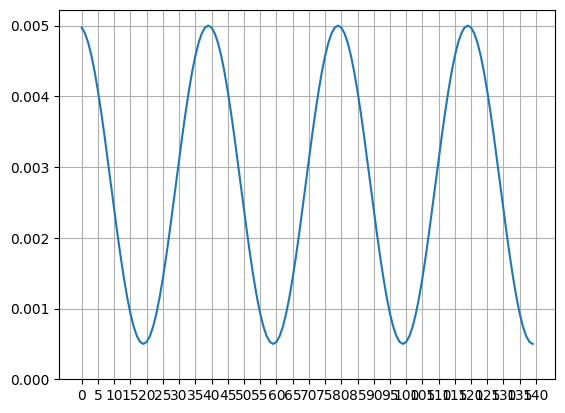

In [13]:
epochs = 140
optimizer = optim.AdamW(params=model.parameters(), lr=5e-3, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=5e-4)
recode_lrs = []
for epoch in range(epochs):
    optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    recode_lrs.append(current_lr)

fig, ax = plt.subplots()
ax.plot(recode_lrs)

x_ticks = np.arange(0, epochs+1, step=5)
y_ticks = np.arange(0, 5.1e-3, step=0.001)

ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
plt.grid(True)
plt.show()